# Tutorial: Use counterfactual texts to mitigate bias

In this notebook you will see how to test a NLP model with for possible bias biaslyze and then use the counterfactual samples to mitigate the bias. We revisit the task from the previous tutorial [](), make sure to check it out first.

## Installation
First install the biaslyze python package from pypi using:

In [1]:
#!pip install biaslyze

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## Load and prepare data

In [3]:
df = pd.read_csv("../data/jigsaw-toxic-comment-classification/train.csv"); df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Now make the classification problem binary: 
Apart from the descriptive multi-label toxicity labels, there is another target column with a binary class signifying if a comment text is toxic or non-toxic.

In [4]:
df["target"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0

## Train a BoW-model

In [5]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

In [6]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression(C=10))

In [7]:
clf.fit(train_df.comment_text, train_df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=10))])

In [8]:
# measure the test performance
y_pred = clf.predict(test_df.comment_text)

score = accuracy_score(test_df.target, y_pred)
print("Test accuracy: {:.2%}".format(score))

Test accuracy: 95.90%


## Counterfactual token based bias detection

Now that we have a model to test, lets evaluate it with the Biaslyze tool and test for bias with regards to the concept 'religion'. 

In [9]:
from biaslyze.bias_detectors import CounterfactualBiasDetector

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
bias_detector = CounterfactualBiasDetector()

In [11]:
counterfactual_detection_results = bias_detector.process(
    texts=train_df.comment_text,
    labels=train_df.target.tolist(),
    predict_func=clf.predict_proba,
    concepts_to_consider=["religion"],
    max_counterfactual_samples_per_text=10,
)

2023-06-29 11:56:08.539 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 106912 texts...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106912/106912 [00:25<00:00, 4150.42it/s]
2023-06-29 11:56:34.306 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 96239 texts with protected concepts.
2023-06-29 11:56:34.307 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:process:138 - Processing concept religion...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96239/96239 [00:30<00:00, 3170.44it/s]
2023-06-29 12:09:38.130 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:_extract_counterfactual_concept_samples:251 - Extracted 36800 counterfactual sa

# Lets look at some results

Here we only look at the religion concept for demonstration purposes.

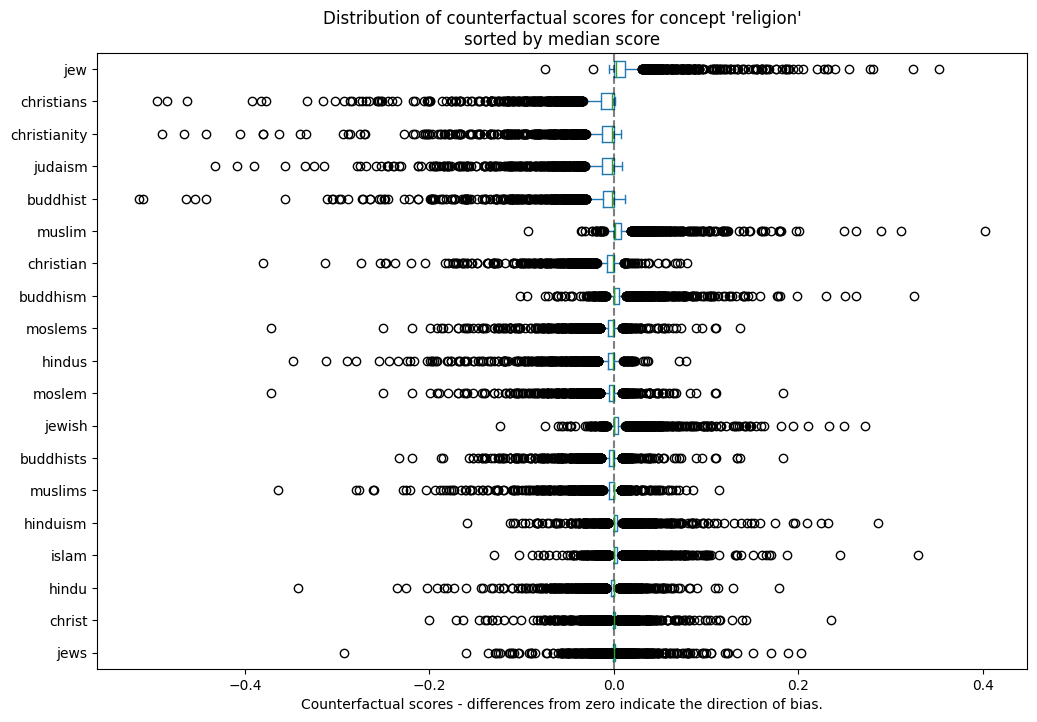

In [12]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="religion", top_n=20)

Here, we see some serious negative bias towards keywords related to jews and muslims.

## Use the counterfactual samples to reduce bias

The bias detection method creates a lot of counterfactual text samples to test for bias. These texts can also be used to retrain or fine-tune a model to reduce this specific bias.

In [13]:
counterfactual_samples = counterfactual_detection_results._get_counterfactual_samples_by_concept(concept="religion")
len(counterfactual_samples)

36800

In [14]:
# prepare texts and labels
counterfactual_texts = [sample.text for sample in counterfactual_samples]
counterfactual_labels = [sample.label for sample in counterfactual_samples]
counterfactual_weights = [2 for sample in counterfactual_samples]

In [15]:
# add sample weight by bias
sample_weights = [0.5] * len(train_df.comment_text.tolist()) + counterfactual_weights

In [16]:
# retrain the model with the augmented dataset
mitigated_clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression(C=10))
mitigated_clf.fit(
    train_df.comment_text.tolist() + counterfactual_texts,
    train_df.target.tolist() + counterfactual_labels,
    logisticregression__sample_weight=sample_weights
)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=10))])

In [17]:
# measure the test performance after the mitigation
y_pred = mitigated_clf.predict(test_df.comment_text)

score = accuracy_score(test_df.target, y_pred)
print("Test accuracy: {:.2%}".format(score))

Test accuracy: 94.82%


Notice, that the mitigation procedure reduced the accuracy a bit.

In [19]:
# evaulate the bias again
mitigaed_counterfactual_detection_results = bias_detector.process(
    texts=train_df.comment_text.sample(10000),
    labels=None,
    predict_func=mitigated_clf.predict_proba,
    concepts_to_consider=["religion"],
    max_counterfactual_samples_per_text=10,
)

2023-06-29 12:11:14.291 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 10000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4053.82it/s]
2023-06-29 12:11:16.766 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 8991 texts with protected concepts.
2023-06-29 12:11:16.767 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:process:138 - Processing concept religion...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8991/8991 [00:02<00:00, 3383.34it/s]
2023-06-29 12:12:28.538 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:_extract_counterfactual_concept_samples:251 - Extracted 3490 counterfactual sampl

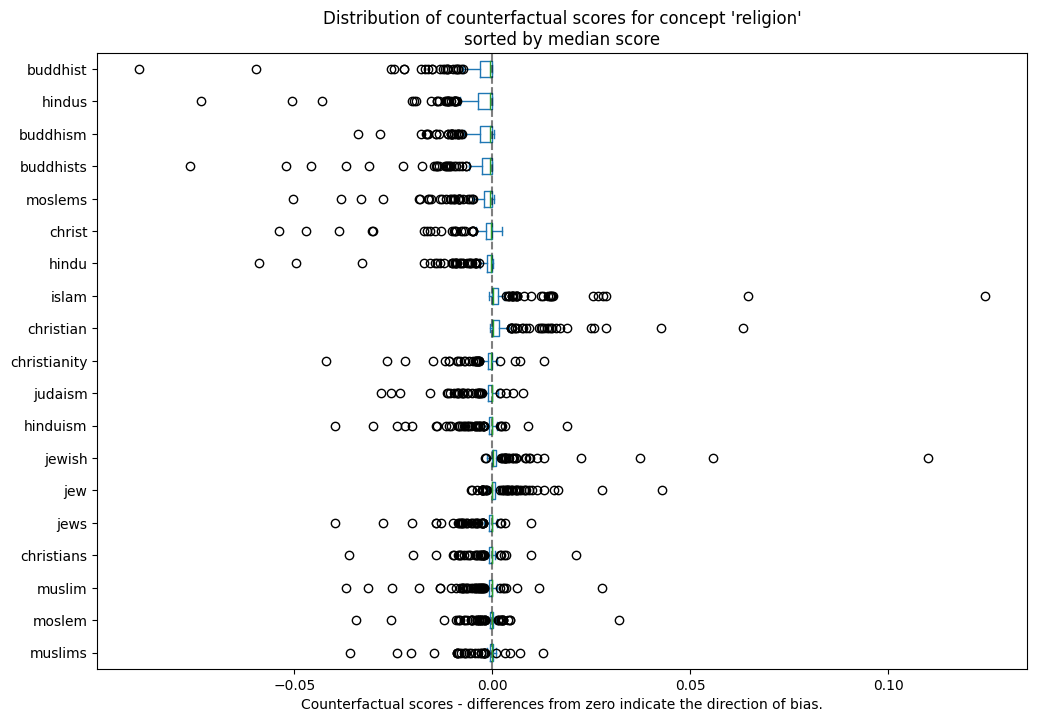

In [20]:
mitigaed_counterfactual_detection_results.visualize_counterfactual_scores(concept="religion", top_n=20)

As we can see, the positive values are reduced and most values are now really close to zero which indicates less bias.